In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Test Poisson regression - Liverpool

## read data

In [2]:
def get_df_team(team, season_start='1011', season_end='1718'):
    df_seasons = []
    
    nseason = int(season_end[:2]) - int(season_start[:2]) + 1
    
    for iseason in range(nseason):
        #season = f'{1011 + 101*iseason}'
        season = f'{int(season_start[:2])+iseason:02d}{int(season_start[2:])+iseason:02d}'
        try:
            df_iseason = pd.read_csv(f'team_data/{season}/{team}.csv')
            df_iseason.insert(0, 'Season', season)
            df_seasons.append(df_iseason)
            #df_seasons.append(pd.read_csv(f'team_data/{season}/{team}.csv'))
        except FileNotFoundError:
            continue
        
    if df_seasons == []:
        raise ValueError("Empty (Wrong name of team?)")
    else:
        df_seasons = pd.concat(df_seasons)
        df_seasons = df_seasons.reset_index(drop=True)
        return df_seasons

In [3]:
df = get_df_team('Liverpool')
print(df.loc[0, 'Date'], 'to', df.loc[len(df)-1, 'Date'])
print('df.shape =', df.shape)

df.columns

2010-08-15 to 2018-05-13
df.shape = (304, 61)


Index(['Season', 'Date', 'Round', 'isHome', 'Rival', 'Goal', 'Conceded',
       'Points', 'CumPoints', 'bCumPoints', 'b5MatchPoints',
       'b5MatchPointRatio', 'bCumGoal', 'b5MatchGoal', 'bCumConceded',
       'b5MatchConceded', 'b5HomeMatchPoints', 'b5HomeMatchPointRatio',
       'bHomeCumGoal', 'bHomeCumConceded', 'b5HomeMatchGoal',
       'b5HomeMatchConceded', 'b5AwayMatchPoints', 'b5AwayMatchPointRatio',
       'bAwayCumGoal', 'bAwayCumConceded', 'b5AwayMatchGoal',
       'b5AwayMatchConceded', 'SelfAS', 'SelfDS', 'SelfFromCL', 'RivalAS',
       'RivalDS', 'RivalFromCL', 'SelfAS.1', 'SelfDS.1', 'SelfFromCL.1',
       'RivalAS.1', 'RivalDS.1', 'RivalFromCL.1', 'bStdCumPoints',
       'bRivalCumPoints', 'bRival5MatchPoints', 'bRival5MatchPointRatio',
       'bRivalCumGoal', 'bRival5MatchGoal', 'bRivalCumConceded',
       'bRival5MatchConceded', 'bRival5HomeMatchPoints',
       'bRival5HomeMatchPointRatio', 'bRivalHomeCumGoal',
       'bRivalHomeCumConceded', 'bRival5HomeMatchGoal'

In [4]:
y = df['Goal']

cols = [
    'Round', 'isHome', 
    'b5MatchGoal', 
    'bRival5MatchGoal', 'bRival5MatchConceded',
    'SelfAS', 'SelfDS', 'RivalAS', 'RivalDS',
    'SelfFromCL', 'RivalFromCL'
]
X = df[cols].copy()

#X['PtDiff'] = df['bCumPoints'] - df['bRivalCumPoints']
X['PtDiff'] = df['bStdCumPoints'] - df['bRivalStdCumPoints']
#X['PtDiff_Round'] = X['Round'] * X['PtDiff']

X['isDec'] = pd.DatetimeIndex(df['Date']).month == 12

# convert all bool-columns into numerical
boolcol = X.dtypes == bool
X.loc[:,boolcol] = X.loc[:,boolcol] + 0

#X = sm.add_constant(X)
X.insert(0, 'const', 1)
X.head()

,const,Round,isHome,b5MatchGoal,bRival5MatchGoal,bRival5MatchConceded,SelfAS,SelfDS,RivalAS,RivalDS,SelfFromCL,RivalFromCL,PtDiff,isDec
0,1,1,1,0.0,0.0,0.0,1.333333,0.735294,1.715686,0.806202,0,0,NaN,0
1,1,2,0,1.0,0.0,0.0,0.882353,0.620155,1.271318,0.980392,0,0,0.000000,0
2,1,3,1,1.0,1.0,6.0,1.333333,0.735294,1.378151,0.650602,0,1,-1.184151,0
3,1,4,0,2.0,6.0,5.0,0.882353,0.620155,0.589147,0.637255,0,0,-0.447331,0
4,1,5,0,2.0,11.0,5.0,0.882353,0.620155,1.612403,0.588235,0,0,-1.146021,0


## fit model with all variables

In [5]:
res = sm.GLM(y, X, family=sm.families.Poisson(), missing='drop').fit()
print('AIC = ', res.aic)
print()

res.summary()

AIC =  1017.4666823857051



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   Goal   No. Observations:                  296
Model:                            GLM   Df Residuals:                      283
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -495.73
Date:                Fri, 25 Dec 2020   Deviance:                       372.72
Time:                        17:19:11   Pearson chi2:                     319.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4893      0.475      1.030      0.303      -0.442       1.420
Round                    0.0022      0.005      0.456      0.648      -0.007       0.011
isHome                   0.1948      0.095      2.051      0.040       0.009       0.381
b5MatchGoal              0.0428      0.013      3.399      0.001       0.018       0.067
bRival5MatchGoal        -0.0149      0.017     -0.865      0.387      -0.049       0.019
bRival5MatchConceded    -0.0112      0.018     -0.622      0.534      -0.046       0.024
SelfAS                  -0.0159      0.142     -0.112      0.911      -0.295       0.263
SelfDS                  -0.0204      0.370     -0.055      0.956      -0.746       0.705
RivalAS                 -0.2026      0.171     -1.186      0.236      -0.537       0.132
RivalDS                 -0.0535      0.223     -0.240      0.810      -0.490       0.383
SelfFromCL            6.661e-18   2.06e-16      0.032      0.974   -3.98e-16    4.11e-16
RivalFromCL              0.0518      0.150      0.346      0.730      -0.242       0.345
PtDiff                   0.0377      0.058      0.653      0.513      -0.075       0.151
isDec                    0.0537      0.121      0.442      0.658      -0.184       0.292
========================================================================================
"""

## find the best model by backward selection

In [6]:
class BackwardElimination:
    def __init__(self, model, y, X, model_kwargs=None, columns=None):
        self.model = model
        self.y = y
        self.X = X
        self.model_kwargs = model_kwargs
        self.columns = columns
        
    def find(self, print_iter=False):
        """return the variables and the minimal AIC"""
        model = self.model
        y = self.y
        X = self.X
        model_kwargs = self.model_kwargs
        
        candidates = set(range(1, X.shape[1]))   # start from 1 to exclude intercept term
        
        # fit full model: `target_aic` should be as lower as possible
        target_aic = model(y, X, **model_kwargs).fit().aic
        
        iiter = 1
        while True:
            cs = []
            aics = []
            for c in candidates:
                aic = self._drop(c, candidates)
                aics.append(aic)
                cs.append(c)
                
            minidx = np.array(aics).argmin()
            
            if print_iter:
                self._print_iteration(iiter, candidates, aics, minidx, target_aic)
            
            if aics[minidx] <= target_aic:
                target_aic = aics[minidx]
                candidates.remove(cs[minidx])
                iiter += 1
            else:
                break
                
        if self.columns is None:
            # add intercept term back
            return [0] + list(candidates), target_aic
        else:
            return self.columns[[0] + list(candidates)], target_aic
    
    def _drop(self, c, candidates):
        """drop `c` in `candidates` and return the AIC"""
        model = self.model
        y = self.y
        X = self.X
        model_kwargs = self.model_kwargs
        
        dropped_cand = [0] + list(candidates.difference({c}))
        return model(y, X[:,dropped_cand], **model_kwargs).fit().aic
    
    def _print_iteration(self, iiter, candidates, aics, minidx, target_aic):
        print('=======================================')
        print('Iteration: ', iiter)
        
        if self.columns is None:
            print('minimal dropped variable: ', minidx)
        else:
            print('minimal dropped variable: ', self.columns[list(candidates)[minidx]])
            
        print('corresponding AIC: ', aics[minidx])
        print('original AIC: ', target_aic)
        if aics[minidx] <= target_aic:
            print('drop or stop:  [Drop]')
        else:
            print('drop or stop:  [Stop]')
            
        print()

In [7]:
idxcol, aic = BackwardElimination(
    sm.GLM, 
    y.values, X.values, 
    model_kwargs={'family': sm.families.Poisson(), 'missing': 'drop'},
    columns = X.columns
).find(print_iter=True)

idxcol, aic

Iteration:  1
minimal dropped variable:  SelfDS
corresponding AIC:  1015.4697051880473
original AIC:  1017.4666823857051
drop or stop:  [Drop]

Iteration:  2
minimal dropped variable:  SelfAS
corresponding AIC:  1013.4882115833659
original AIC:  1015.4697051880473
drop or stop:  [Drop]

Iteration:  3
minimal dropped variable:  RivalDS
corresponding AIC:  1011.5420651925389
original AIC:  1013.4882115833659
drop or stop:  [Drop]

Iteration:  4
minimal dropped variable:  isDec
corresponding AIC:  1009.7313487368906
original AIC:  1011.5420651925389
drop or stop:  [Drop]

Iteration:  5
minimal dropped variable:  Round
corresponding AIC:  1007.8745680998597
original AIC:  1009.7313487368906
drop or stop:  [Drop]

Iteration:  6
minimal dropped variable:  bRival5MatchConceded
corresponding AIC:  1006.2112108144784
original AIC:  1007.8745680998597
drop or stop:  [Drop]

Iteration:  7
minimal dropped variable:  RivalFromCL
corresponding AIC:  1004.5276782897354
original AIC:  1006.21121081447

(Index(['const', 'isHome', 'b5MatchGoal', 'PtDiff'], dtype='object'),
 1002.7801669805915)

In [8]:
res = sm.GLM(y, X[idxcol], family=sm.families.Poisson(), missing='drop').fit(scale='X2')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   Goal   No. Observations:                  296
Model:                            GLM   Df Residuals:                      292
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.1112
Method:                          IRLS   Log-Likelihood:                -447.61
Date:                Fri, 25 Dec 2020   Deviance:                       376.04
Time:                        17:19:21   Pearson chi2:                     324.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0986      0.125      0.791      0.429      -0.146       0.343
isHome          0.1991      0.091      2.181      0.029       0.020       0.378
b5MatchGoal     0.0390      0.011      3.397      0.001       0.017       0.062
PtDiff          0.0752      0.042      1.774      0.076      -0.008       0.158
===============================================================================
"""

In [9]:
print('Pearson chi2 for this model:')
res.pearson_chi2

Pearson chi2 for this model:


324.4712890315841

## compare the Poisson regression model with `HomeAwayModel` and `PoiDistModel`

In [10]:
def calc_pearson_chi2(predict, obs, var_func):
    return np.sum((predict - obs) ** 2 / var_func(predict))

In [11]:
from simple_model.home_away_model import HomeAwayModel
from simple_model.poidist_model import PoiDistModel

homeaway_res = []
poidist_res = []

for i, row in df.iterrows():
    season = row['Season']
    team = 'Liverpool'
    rival = row['Rival']
    is_home = row['isHome']
    
    mu_ha = HomeAwayModel(season, team, is_home).mu
    mu_pd = PoiDistModel(season, team, rival, is_home).mu
    
    homeaway_res.append(mu_ha)
    poidist_res.append(mu_pd)

In [12]:
print('Pearson chi2 for HomeAwayModel and PoiDistModel:')
print(calc_pearson_chi2(np.array(homeaway_res), y.values, lambda mu: mu))
print(calc_pearson_chi2(np.array(poidist_res), y.values, lambda mu: mu))

Pearson chi2 for HomeAwayModel and PoiDistModel:
439.65105446127586
633.3456837322947


# Build models for all teams in 18/19 season

trainning data: 10/11 to 17/18 season

In [13]:
allteams = list(
    map(
        lambda s: s.split('.csv')[0],
        filter(lambda s: s.endswith('.csv'), os.listdir('team_data/1819/'))
    )
)

# Dict[str_team_name, df]
team_df_dict = {team: get_df_team(team) for team in allteams}
team_df_dict.keys()

dict_keys(['Arsenal', 'Bournemouth', 'Brighton', 'Burnley', 'Cardiff', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield', 'Leicester', 'Liverpool', 'Man City', 'Man Utd', 'Newcastle', 'Southampton', 'Spurs', 'Watford', 'West Ham', 'Wolves'])

In [14]:
team_X_dict = {}    # Dict[str_team_name, X]
team_y_dict = {}    # Dict[str_team_name, y]

for team, df in team_df_dict.items():
    y = df['Goal']

    cols = [
        'Round', 'isHome', 
        'b5MatchGoal', 
        'bRival5MatchGoal', 'bRival5MatchConceded',
        'SelfAS', 'SelfDS', 'RivalAS', 'RivalDS',
        'SelfFromCL', 'RivalFromCL'
    ]
    X = df[cols].copy()

    X['PtDiff'] = df['bStdCumPoints'] - df['bRivalStdCumPoints']
    #X['PtDiff_Round'] = X['Round'] * X['PtDiff']

    X['isDec'] = pd.DatetimeIndex(df['Date']).month == 12

    # convert all bool-columns into numerical
    boolcol = X.dtypes == bool
    X.loc[:,boolcol] = X.loc[:,boolcol] + 0

    #X = sm.add_constant(X)
    X.insert(0, 'const', 1)
    
    team_X_dict[team] = X
    team_y_dict[team] = y

In [15]:
team_res_dict = {}   # Dict[str_team_name, GLM_result_obj]

for team in allteams:
    print(team, end=' / ')
    
    y = team_y_dict[team]
    X = team_X_dict[team]

    idxcol, aic = BackwardElimination(
        sm.GLM, 
        y.values, X.values, 
        model_kwargs={'family': sm.families.Poisson(), 'missing': 'drop'},
        columns = X.columns
    ).find(print_iter=False)
    
    res = sm.GLM(y, X[idxcol], family=sm.families.Poisson(), missing='drop').fit(scale='X2')
    team_res_dict[team] = res
    
print()

Arsenal / Bournemouth / Brighton / Burnley / Cardiff / Chelsea / Crystal Palace / Everton / Fulham / Huddersfield / Leicester / Liverpool / Man City / Man Utd / Newcastle / Southampton / Spurs / Watford / West Ham / Wolves / 


## check the variables of each model

In [16]:
df_regvar = pd.DataFrame(
    index=team_res_dict.keys(),                # teams
    columns=team_X_dict[allteams[0]].columns   # all possible variables
)

for team, res in team_res_dict.items():
    col = team_res_dict[team].params.index
    #df_regvar.loc[team, res.model.exog_names] = True
    df_regvar.loc[team, col] = team_res_dict[team].params
    
df_regvar

,const,Round,isHome,b5MatchGoal,bRival5MatchGoal,bRival5MatchConceded,SelfAS,SelfDS,RivalAS,RivalDS,SelfFromCL,RivalFromCL,PtDiff,isDec
Arsenal,0.0104621,NaN,0.240191,-0.0314042,NaN,NaN,NaN,NaN,NaN,0.731727,NaN,0.468543,0.0301167,NaN
Bournemouth,-1.25089,0.0130053,NaN,-0.100695,NaN,NaN,NaN,1.47756,NaN,NaN,0.901,0.38407,0.224531,NaN
Brighton,-2.81502,NaN,NaN,NaN,0.125267,NaN,4.49432,NaN,-1.04318,1.27127,-2.81502,NaN,NaN,-1.33292
Burnley,-16.9733,NaN,2.26117,NaN,NaN,0.0924922,3.35784,11.9033,NaN,0.680428,4.73594,NaN,-0.0879328,NaN
Cardiff,0.737457,0.0359721,NaN,-0.180519,0.109896,-0.171922,NaN,NaN,NaN,NaN,NaN,-1.66947,0.527365,NaN
Chelsea,1.15823,NaN,0.299039,NaN,-0.0408103,NaN,-0.372421,NaN,NaN,NaN,NaN,NaN,0.0516436,NaN
Crystal Palace,0.502041,0.0111717,NaN,NaN,NaN,NaN,NaN,NaN,-0.476104,NaN,-0.267032,NaN,0.1096,NaN
Everton,0.0574897,NaN,0.47489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.165376,NaN
Fulham,0.539407,NaN,0.779271,NaN,NaN,0.0538533,-0.872847,NaN,-0.419408,NaN,NaN,0.337584,0.0589037,NaN
Huddersfield,-1.47377,NaN,NaN,-0.269181,0.16485,NaN,3.1358,1.75724,-1.83199,NaN,-1.47377,NaN,0.242948,1.2787


## check the model fittness

In [17]:
# the scale of pearson chi2 would be different because the number of data is different

for team, res in team_res_dict.items():
    print(f'{team:15} {res.pearson_chi2:7.3f} {res.pearson_chi2/res.nobs:7.3f}')

Arsenal         272.405   0.920
Bournemouth      96.622   0.870
Brighton         21.039   0.554
Burnley          78.588   0.708
Cardiff          36.908   0.998
Chelsea         288.976   0.976
Crystal Palace  197.927   1.070
Everton         258.500   0.873
Fulham          124.372   0.840
Huddersfield     41.542   1.123
Leicester       139.145   0.940
Liverpool       324.471   1.096
Man City        294.466   0.995
Man Utd         258.774   0.877
Newcastle       276.494   1.068
Southampton     247.949   1.117
Spurs           284.540   0.961
Watford         112.553   1.014
West Ham        217.942   0.841
Wolves           61.899   0.836


# `PredictGoals`: using the previous models to predict the match results

In [18]:
from scipy.stats import norm, poisson


class PredictGoals:
    def __init__(self, team_res_dict):
        self.team_res_dict = team_res_dict
        
    def _read_team_data(self, season):
        """
        return a dict: Dict[str_team_name, df_of_team]
        the df is from /team_data/<season>/*.csv
        """
        allteams = list(
            map(
                lambda s: s.replace('.csv', ''),
                filter(
                    lambda s: s.endswith('.csv'),
                    os.listdir(f'team_data/{season}/')
                )
            )
        )
        
        team_data_dict = {}
        for team in allteams:
            df = pd.read_csv(f'team_data/{season}/{team}.csv')
            team_data_dict[team] = df
            
        return team_data_dict
    
    def _convert_to_reg_data(self, team_data_dict):
        """
        Extract variables from team_data_dict, and convert to the variables used
        in regression model.
        Input: 
            team_data_dict is from self._read_team_data()
        Return:
            (reg_y_dict, reg_data_dict)
            reg_y_dict    : Dict[str_team_name, goals]  
            reg_data_dict : Dict[str_team_name, df_reg_data] 
            All of `df_reg_data` have the same columns.
        """
        reg_y_dict = {}      
        reg_data_dict = {}  
        
        cols = [
            'Round', 'isHome', 
            'b5MatchGoal', 
            'bRival5MatchGoal', 'bRival5MatchConceded',
            'SelfAS', 'SelfDS', 'RivalAS', 'RivalDS',
            'SelfFromCL', 'RivalFromCL'
        ]
        
        for team, df_team_data in team_data_dict.items():
            X = df_team_data[cols].copy()
            
            X['PtDiff'] = df_team_data['bStdCumPoints'] - df_team_data['bRivalStdCumPoints']
            X['PtDiff_Round'] = X['Round'] * X['PtDiff']
            
            X['isDec'] = pd.DatetimeIndex(df_team_data['Date']).month == 12
            
            # convert all bool-columns into numerical
            boolcol = X.dtypes == bool
            X.loc[:,boolcol] = X.loc[:,boolcol] + 0

            #X = sm.add_constant(X)
            X.insert(0, 'const', 1)
            
            reg_y_dict[team] = df_team_data['Goal'].values
            reg_data_dict[team] = X
            
        return reg_y_dict, reg_data_dict

    def _conf_int_mu(self, X, beta, cov_mat, inv_link_func, alpha=0.05):
        """
        parameter
            X.shape = (n, p)
            beta.shape = (p,)
            cov_mat.shape = (p, p)
            inv_link_func : inverse link function
            alpha : scalar between 0 ~ 1
        return : 
            ci, ci.shape = (n, 2)
            ci[:,0] is the lower bound and ci[:,1] for upper bound
        """
        eta = X @ beta     # (n,)
        
        eta_stderr = []    # (n,)
        for xi in X:
            eta_stderr.append(np.sqrt(xi @ cov_mat @ xi[:,np.newaxis]))
        eta_stderr = np.array(eta_stderr).ravel()
        
        z_cri = norm.ppf(1-alpha/2)
        
        ci_lower = inv_link_func(eta - z_cri * eta_stderr)
        ci_upper = inv_link_func(eta + z_cri * eta_stderr)
        ci = np.vstack((ci_lower, ci_upper)).T
        return ci
        
    def predict_by_real_data(self, season, alpha=0.05, ci_adjust=False):
        """ 
        e.g. season = '1920' . alpha is for ci
        """
        team_res_dict = self.team_res_dict
        
        # Dict[str_team_name, df_of_team]
        # the df is read from: /team_data/<season>/<team_name>.csv
        team_data_dict = self._read_team_data(season)
        
        # Dict[str_team_name, Array_goals] and Dict[str_team_name, df_of_team_data]
        reg_y_dict, reg_data_dict = self._convert_to_reg_data(team_data_dict)
        
        # Dict[str_team_name, df_predict_result]
        predict_res = {}
        
        # predict
        for team, reg_data in reg_data_dict.items():           
            glmres = team_res_dict[team]
            var_col = glmres.model.exog_names
            
            y = reg_y_dict[team]    # (nobs,)
            X = reg_data_dict[team].loc[:,var_col]   # (nobs, nfeatures)
            
            mu = glmres.predict(X)   # (nobs,)
            predict_goals = np.floor(mu)
            ci = self._conf_int_mu(
                X.values, 
                glmres.params.values, 
                glmres.cov_params().values, 
                glmres.model.family.link.inverse,
                alpha
            )
            
            predict_res[team] = pd.DataFrame({
                'Rival': team_data_dict[team].loc[:,'Rival'].values,
                'isHome': team_data_dict[team].loc[:,'isHome'].values,
                'obs': y,
                'mu': mu,
                'ci': ci.tolist(),
                'predict': predict_goals
            })
            
        # merge the predict result of rivals
        # adding columns: 'Rival_obs', 'Rival_mu', 'Rival_predict', 'is_win_obs', 'is_win_predict_sep'
        for team in reg_data_dict.keys():
            predict_res[team] = self._merge_rival_predict(predict_res, team)
            
        # adding columns: 'prob_win', 'prob_draw', 'prob_loss'
        for team in reg_data_dict.keys():
            predict_res[team] = self._calc_prob(predict_res, team)
            
        # adding column: 'is_win_predict_jnt'
        for team in reg_data_dict.keys():
            predict_res[team] = self._calc_is_win_predict_jnt(predict_res, team, ci_adjust)
        
        # change order of column
        for team in reg_data_dict.keys():
            new_col = [
                'Rival', 'isHome',
                'obs', 'Rival_obs', 
                'mu', 'ci', 'Rival_mu', 'Rival_ci',
                'predict', 'Rival_predict',
                'prob_win', 'prob_draw', 'prob_loss',
                'is_win_obs', 'is_win_predict_sep', 'is_win_predict_jnt'
            ]
            predict_res[team] = predict_res[team][new_col]
            predict_res[team]['Rival_obs'] = predict_res[team]['Rival_obs'].astype(int)
        
        return predict_res
    
    def _merge_rival_predict(self, predict_res, team):
        """predict_res is from self.predict_by_real_data"""
        team_pred_res = predict_res[team].copy()
        rivals = team_pred_res['Rival'].unique()
        
        team_pred_res['Rival_obs'] = np.nan
        team_pred_res['Rival_mu'] = np.nan
        team_pred_res['Rival_ci'] = np.nan
        team_pred_res['Rival_predict'] = np.nan
        
        # merge rival goals
        for rival in rivals:
            rival_pred_res = predict_res[rival]
            idx = rival_pred_res['Rival'] == team
            rival_obs_goal = rival_pred_res.loc[idx, 'obs'].values
            rival_mu_goal = rival_pred_res.loc[idx, 'mu'].values
            rival_ci_goal = rival_pred_res.loc[idx, 'ci'].values
            rival_pred_goal = rival_pred_res.loc[idx, 'predict'].values
            
            idx2 = team_pred_res['Rival'] == rival
            team_pred_res.loc[idx2, 'Rival_obs'] = rival_obs_goal
            team_pred_res.loc[idx2, 'Rival_mu'] = rival_mu_goal
            team_pred_res.loc[idx2, 'Rival_ci'] = rival_ci_goal
            team_pred_res.loc[idx2, 'Rival_predict'] = rival_pred_goal
        
        # compute the match result
        team_pred_res['is_win_obs'] = np.nan
        team_pred_res.loc[team_pred_res.obs > team_pred_res.Rival_obs, 'is_win_obs'] = 'Win'
        team_pred_res.loc[team_pred_res.obs == team_pred_res.Rival_obs, 'is_win_obs'] = 'Draw'
        team_pred_res.loc[team_pred_res.obs < team_pred_res.Rival_obs, 'is_win_obs'] = 'Loss'
        
        team_pred_res['is_win_predict_sep'] = np.nan
        team_pred_res.loc[team_pred_res.predict > team_pred_res.Rival_predict, 'is_win_predict_sep'] = 'Win'
        team_pred_res.loc[team_pred_res.predict == team_pred_res.Rival_predict, 'is_win_predict_sep'] = 'Draw'
        team_pred_res.loc[team_pred_res.predict < team_pred_res.Rival_predict, 'is_win_predict_sep'] = 'Loss'
        
        return team_pred_res
    
    def _calc_prob(self, predict_res, team):
        """
        Calculate win/draw/loss probability based on `predict` and `Rival_predict`.
        `predict_res` is from self.predict_by_real_data
        """
        team_pred_res = predict_res[team].copy()
        
        # mu: parameter of poisson distribution
        mu_team = team_pred_res['mu'].values   # (nobs,)
        mu_rival = team_pred_res['Rival_mu'].values   # (nobs,)
        
        # goals (row vector), size=15
        k = np.arange(15)[np.newaxis,:]    
        
        # calculate the probability
        prob = []    # List[List[float]]
        
        for mu_tm, mu_rvl in zip(mu_team, mu_rival):
            joint_pmf = poisson.pmf(k, mu_tm) * poisson.pmf(k.T, mu_rvl)   # (15, 15) 
            prob_win = np.triu(joint_pmf, k=1).sum()     # upper part for win
            prob_draw = np.diag(joint_pmf).sum()         # diagonal for draw
            prob_loss = np.tril(joint_pmf, k=-1).sum()   # lower part for loss
            prob.append([prob_win, prob_draw, prob_loss])
            
        prob_df = pd.DataFrame(prob, columns=['prob_win', 'prob_draw', 'prob_loss'])
        team_pred_res = pd.concat([team_pred_res, prob_df], axis=1)
        return team_pred_res
    
    def _calc_is_win_predict_jnt(self, predict_res, team, ci_adjust=False):
        """
        Calculate `is_win_predict_jnt` column
        It just simply find the max one among three columns: 'prob_win', 'prob_draw' and 'prob_loss'.
        If ci_adjust is True, `is_win_predict_jnt` will be 'Draw' when the difference between `mu` and 
        `Rival_mu` are not sifnificant (based on columns `ci` and `Rival_ci`).
        """
        def find_is_win(row):
            maxprob = row.astype(float).idxmax()
            if maxprob == 'prob_win':
                return 'Win'
            elif maxprob == 'prob_draw':
                return 'Draw'
            elif maxprob == 'prob_loss':
                return 'Loss'
        
        team_pred_res = predict_res[team].copy()
        is_win_predict_jnt = team_pred_res[['prob_win', 'prob_draw', 'prob_loss']].apply(find_is_win, axis=1)
        team_pred_res['is_win_predict_jnt'] = is_win_predict_jnt
        
        if ci_adjust:
            isoverlap = team_pred_res[['ci', 'Rival_ci']].apply(self._is_overlap, axis=1)
            team_pred_res.loc[isoverlap, 'is_win_predict_jnt'] = 'Draw'
        
        return team_pred_res
    
    def _is_overlap(self, lists):
        """
        lists = [list1, list2]
        check is list1 and list2 are overlap
        e.g. list1 = [0, 8], list2 = [5, 10]   ->   True
             list1 = [0, 8], list2 = [9, 12]   ->   False
        """
        list1, list2 = lists
        if np.any(np.isnan(list1)) or np.any(np.isnan(list2)):
            return False
        if max(list1) >= max(list2):
            return False if min(list1) >= max(list2) else True
        else:
            return False if min(list2) >= max(list1) else True

In [19]:
pred_res_dict = PredictGoals(team_res_dict).predict_by_real_data('1819', alpha=0.35, ci_adjust=True)
pred_res_dict['Liverpool'].head(10)

,Rival,isHome,obs,Rival_obs,mu,ci,Rival_mu,Rival_ci,predict,Rival_predict,prob_win,prob_draw,prob_loss,is_win_obs,is_win_predict_sep,is_win_predict_jnt
0,West Ham,True,4,0,NaN,"[nan, nan]",NaN,"[nan, nan]",NaN,NaN,NaN,NaN,NaN,Win,NaN,None
1,Crystal Palace,False,2,0,1.290051,"[1.1833606100627463, 1.4063594811737372]",0.720824,"[0.5600765611919015, 0.9277071537618985]",1.0,0.0,0.501171,0.290469,0.208360,Win,Win,Win
2,Brighton,True,1,0,1.868970,"[1.7340089723009144, 2.014435099690737]",0.356358,"[0.20136487366541414, 0.6306520747704669]",1.0,0.0,0.744724,0.192889,0.062387,Win,Win,Win
3,Leicester,False,2,1,1.558323,"[1.4545300185279986, 1.669522539639848]",1.651708,"[1.4295167949652157, 1.9084345333337238]",1.0,1.0,0.363288,0.233594,0.403118,Win,Draw,Draw
4,Spurs,False,2,1,1.664490,"[1.5630010243983785, 1.772569932010711]",1.599993,"[1.4750579931260077, 1.735510251884346]",1.0,1.0,0.397888,0.231530,0.370583,Win,Draw,Draw
5,Southampton,True,3,0,2.453699,"[2.254430633529224, 2.6705799472301974]",0.778063,"[0.6671941949839818, 0.907356180315287]",2.0,0.0,0.741969,0.159473,0.098558,Win,Win,Win
6,Chelsea,False,1,1,1.680657,"[1.5739997866161155, 1.7945417050005907]",1.904728,"[1.716489000626862, 2.1136099040376064]",1.0,1.0,0.345354,0.218543,0.436103,Draw,Draw,Draw
7,Man City,True,0,0,1.913396,"[1.797793113423266, 2.0364314749437162]",1.548819,"[1.3585568195704492, 1.7657264367619678]",1.0,1.0,0.464512,0.220563,0.314925,Draw,Draw,Win
8,Huddersfield,False,1,0,1.851022,"[1.671027801039909, 2.0504049809398395]",0.312628,"[0.03575302297970668, 2.733657018043608]",1.0,0.0,0.753463,0.191659,0.054878,Win,Win,Draw
9,Cardiff,True,4,1,2.149264,"[1.9358686006246595, 2.3861819662827455]",0.397485,"[0.20343284285371713, 0.7766428014331117]",2.0,0.0,0.783280,0.160983,0.055737,Win,Win,Win


# Confuse Matrix

In [21]:
class ConfuseMatrix:
    def __init__(self, pred_res_dict):
        """
        e.g. 
        >>> pred_res_dict = PredictGoals(team_res_dict).predict_by_real_data('1819')
        >>> confuse_matrix(pred_res_dict['Liverpool'])
        """
        self.pred_res_dict = pred_res_dict
        
    def confuse_matrix_by_team(self, team, divide_n=False, use='is_win_predict_sep'):
        """
        team : str, name of the team
        divide_n : bool, False for counting and True for proportion
        use : str, determine use 'is_win_predict_sep' or 'is_win_predict_jnt'
        """
        team_pred_res = self.pred_res_dict[team].dropna(axis=0)
        n = team_pred_res.shape[0]

        is_win_obs = team_pred_res['is_win_obs']
        is_win_pred = team_pred_res[use]

        # ww: observaed win, predict win; wd: observed win, predict draw; ...
        ww = ((is_win_obs == 'Win') & (is_win_pred == 'Win')).sum()
        wd = ((is_win_obs == 'Win') & (is_win_pred == 'Draw')).sum()
        wl = ((is_win_obs == 'Win') & (is_win_pred == 'Loss')).sum()

        dw = ((is_win_obs == 'Draw') & (is_win_pred == 'Win')).sum()
        dd = ((is_win_obs == 'Draw') & (is_win_pred == 'Draw')).sum()
        dl = ((is_win_obs == 'Draw') & (is_win_pred == 'Loss')).sum()

        lw = ((is_win_obs == 'Loss') & (is_win_pred == 'Win')).sum()
        ld = ((is_win_obs == 'Loss') & (is_win_pred == 'Draw')).sum()
        ll = ((is_win_obs == 'Loss') & (is_win_pred == 'Loss')).sum()

        confuse_mat = np.array([
            [ww, dw, lw],
            [wd, dd, ld],
            [wl, dl, ll]
        ])
        if divide_n:
            confuse_mat = confuse_mat / n

        df = pd.DataFrame(confuse_mat)
        df.index = ['Win', 'Draw', 'Loss']
        df.columns = ['Win', 'Draw', 'Loss']
        df.index.name = 'Predict'
        df.columns.name = 'Obs'

        return df
    
    def confuse_matrix_by_allteam(self, divide_n=False, use='is_win_predict_sep'):
        allres = []
        for team, team_pred in pred_res_dict.items():
            allres.append(team_pred)
    
        allres = pd.concat(allres)
        allres = allres.loc[allres.isHome,:].drop('isHome', axis=1).dropna(axis=0).reset_index(drop=True)
    
        n = allres.shape[0]
    
        is_win_obs = allres['is_win_obs']
        is_win_pred = allres[use]
        
        # ww: observaed win, predict win; wd: observed win, predict draw; ...
        ww = ((is_win_obs == 'Win') & (is_win_pred == 'Win')).sum()
        wd = ((is_win_obs == 'Win') & (is_win_pred == 'Draw')).sum()
        wl = ((is_win_obs == 'Win') & (is_win_pred == 'Loss')).sum()
        
        dw = ((is_win_obs == 'Draw') & (is_win_pred == 'Win')).sum()
        dd = ((is_win_obs == 'Draw') & (is_win_pred == 'Draw')).sum()
        dl = ((is_win_obs == 'Draw') & (is_win_pred == 'Loss')).sum()
        
        lw = ((is_win_obs == 'Loss') & (is_win_pred == 'Win')).sum()
        ld = ((is_win_obs == 'Loss') & (is_win_pred == 'Draw')).sum()
        ll = ((is_win_obs == 'Loss') & (is_win_pred == 'Loss')).sum()
        
        confuse_mat = np.array([
            [ww, dw, lw],
            [wd, dd, ld],
            [wl, dl, ll]
        ])
        if divide_n:
            confuse_mat = confuse_mat / n
        
        df = pd.DataFrame(confuse_mat)
        df.index = ['Win', 'Draw', 'Loss']
        df.columns = ['Win', 'Draw', 'Loss']
        df.index.name = 'Predict'
        df.columns.name = 'Obs'
    
        return df

    def indicator(self, confuse_mat, beta=1):
        """
        confuse_mat is from self.confuse_matrix_by_allteam(divide_n=False) or
        self.confuse_matrix_by_team(team, divide_n=False)
        beta is for F1 measure (beta=1 for equal weight)
        """
        n = confuse_mat.values.sum()
        
        if n <= 1:
            raise ValueError("`divide_n` should be False when computing the confuse matrix")
            
        accuracy = np.diag(confuse_mat.values).sum() / n
        
        precision_w = confuse_mat.loc['Win','Win'] / confuse_mat.loc['Win',:].values.sum()
        precision_d = confuse_mat.loc['Draw','Draw'] / confuse_mat.loc['Draw',:].values.sum()
        precision_l = confuse_mat.loc['Loss','Loss'] / confuse_mat.loc['Loss',:].values.sum()
        
        recall_w = confuse_mat.loc['Win','Win'] / confuse_mat.loc[:,'Win'].values.sum()
        recall_d = confuse_mat.loc['Draw','Draw'] / confuse_mat.loc[:,'Draw'].values.sum()
        recall_l = confuse_mat.loc['Loss','Loss'] / confuse_mat.loc[:,'Loss'].values.sum()
        
        f1_w = (1+beta**2) * precision_w * recall_w / ((beta**2 * precision_w) + recall_w)
        f1_d = (1+beta**2) * precision_d * recall_d / ((beta**2 * precision_d) + recall_d)
        f1_l = (1+beta**2) * precision_l * recall_l / ((beta**2 * precision_l) + recall_l)
        
        df = pd.DataFrame([
            [accuracy],
            [precision_w],
            [precision_d],
            [precision_l],
            [recall_w],
            [recall_d],
            [recall_l],
            [f1_w],
            [f1_d],
            [f1_l]
        ])
        df = pd.Series([accuracy, precision_w, precision_d, precision_l, recall_w, recall_d, recall_l, f1_w, f1_d, f1_l])

        df.index = pd.MultiIndex.from_tuples([
            ('Accuracy', '-'),
            ('Precision', 'Win'),
            ('Precision', 'Draw'),
            ('Precision', 'Loss'),
            ('Recall', 'Win'),
            ('Recall', 'Draw'),
            ('Recall', 'Loss'),
            ('F1 Score', 'Win'),
            ('F1 Score', 'Draw'),
            ('F1 Score', 'Loss')
        ])
        
        return df

## create a confuse matrix

In [22]:
cm = ConfuseMatrix(pred_res_dict)

print('===== use is_win_predict_sep =====')
print('----------------------------------')
print('********* confuse matrix *********')
print(cm.confuse_matrix_by_allteam(divide_n=True))
print()
print('*********** indicator ************')
print(cm.indicator(cm.confuse_matrix_by_allteam(divide_n=False)))
print()
print()

print('===== use is_win_predict_jnt =====')
print('----------------------------------')
print('********* confuse matrix *********')
print(cm.confuse_matrix_by_allteam(divide_n=True, use='is_win_predict_jnt'))
print()
print('*********** indicator ************')
print(cm.indicator(cm.confuse_matrix_by_allteam(divide_n=False, use='is_win_predict_jnt')))


===== use is_win_predict_sep =====
----------------------------------
********* confuse matrix *********
Obs           Win      Draw      Loss
Predict                              
Win      0.272973  0.097297  0.102703
Draw     0.151351  0.062162  0.116216
Loss     0.054054  0.027027  0.116216

*********** indicator ************
Accuracy   -       0.451351
Precision  Win     0.577143
           Draw    0.188525
           Loss    0.589041
Recall     Win     0.570621
           Draw    0.333333
           Loss    0.346774
F1 Score   Win     0.573864
           Draw    0.240838
           Loss    0.436548
dtype: float64


===== use is_win_predict_jnt =====
----------------------------------
********* confuse matrix *********
Obs           Win      Draw      Loss
Predict                              
Win      0.289189  0.097297  0.100000
Draw     0.124324  0.059459  0.102703
Loss     0.064865  0.029730  0.132432

*********** indicator ************
Accuracy   -       0.481081
Precision  Wi

## check the accuracy of each team

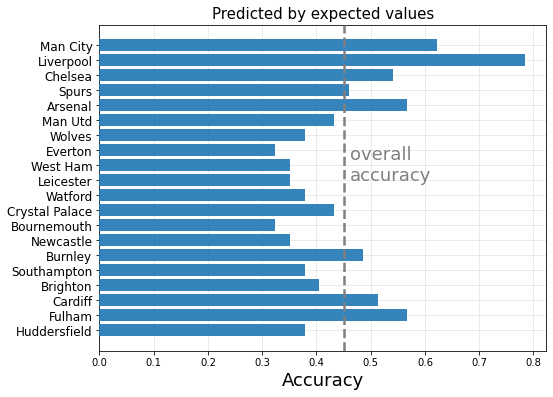

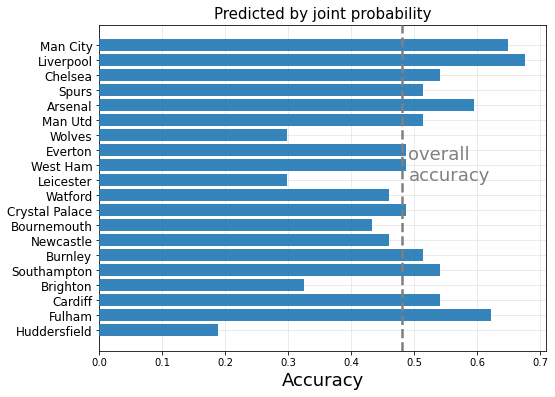

In [23]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")   # it would raise a warning during the calculation of f1 score, but I don't care

    allteams = pd.read_csv('table/1819.csv')['Team'].values   # sorted by rank
    
    titles = ['Predicted by expected values', 'Predicted by joint probability']
    uses = ['is_win_predict_sep', 'is_win_predict_jnt']
    
    for title, use in zip(titles, uses):

        cm = ConfuseMatrix(pred_res_dict)
        accu = []
        for team in allteams:
            conf_mat = cm.confuse_matrix_by_team(team, use=use)
            accu.append(
                cm.indicator(conf_mat).loc[('Accuracy', '-')]
            )

        accu_all = cm.indicator(cm.confuse_matrix_by_allteam(use=use)).loc[('Accuracy', '-')]

        plt.figure(figsize=(8, 6))
        plt.barh(allteams[::-1], accu[::-1], alpha=0.9, zorder=5)

        ylim = plt.ylim()
        plt.vlines(x=accu_all, ymin=ylim[0], ymax=ylim[1], colors='gray', ls='dashed', lw=2.5, zorder=10)
        plt.text(x=accu_all+0.01, y=10, s='overall\naccuracy', fontsize=18, color='gray')
        plt.ylim(*ylim)

        plt.xlabel('Accuracy', fontsize=18)
        plt.yticks(fontsize=12)
        plt.title(title, fontsize=15)
        plt.grid(alpha=0.3, zorder=0)

0.05
0.15000000000000002
0.25000000000000006
0.35000000000000003
0.45000000000000007
0.5500000000000002
0.6500000000000001
0.7500000000000002
0.8500000000000002
0.9500000000000002


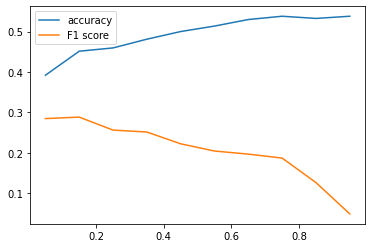

In [24]:
# check the sensitivity of alpha (used in ci_adjust)

accuracy = []
f1score = []

alpha = np.arange(0.05, 0.95+0.1, 0.1)

for a in alpha:
    print(a)
    pred_res_dict = PredictGoals(team_res_dict).predict_by_real_data('1819', alpha=a, ci_adjust=True)
    
    cm = ConfuseMatrix(pred_res_dict)
    confuse_mat = cm.confuse_matrix_by_allteam(divide_n=False, use='is_win_predict_jnt')
    
    indicator = cm.indicator(confuse_mat)
    accu = indicator.loc[('Accuracy', '-')]
    f1 = indicator.loc[('F1 Score', 'Draw')]
    
    accuracy.append(accu)
    f1score.append(f1)
    

# plot
plt.plot(alpha, accuracy, label='accuracy')
plt.plot(alpha, f1score, label='F1 score')
plt.legend()

# 所以之前取0.35好像還算OK

# Simulate the whole 18/19 season

Given the first five matches, the remaining matches will be simulated by the previous models

In [86]:
from numpy.random import lognormal


class SimulateAllSeason:
    def __init__(self, season, team_res_dict):
        self.season = season
        self.team_res_dict = team_res_dict
        
        self.matchs_df = pd.read_csv(f'clean_data/{season}.csv').sort_values('Date', ignore_index=True).drop('Unnamed: 0', axis=1)
        
        self.fixture_df = self.matchs_df[['Date', 'HomeTeam', 'AwayTeam']].copy()
        self.allteams = self.matchs_df['HomeTeam'].unique()
        self.progress_df = pd.DataFrame([], columns=['Date', 'HomeTeam', 'HomeScore', 'AwayScore', 'AwayTeam', 'Winner'])
        
        # all possible regression variables
        self.cols = [
            'Round', 'isHome', 
            'b5MatchGoal', 
            'bRival5MatchGoal', 'bRival5MatchConceded',
            'SelfAS', 'SelfDS', 'RivalAS', 'RivalDS',
            'SelfFromCL', 'RivalFromCL',
            'PtDiff', 'isDec'
        ]
        
    def _create_table(self):
        """create table based on `self.progress_df`"""
        progress_df = self.progress_df
        table = []
        
        for team in self.allteams:
            idx_home = progress_df['HomeTeam'] == team
            idx_away = progress_df['AwayTeam'] == team
            idx = idx_home | idx_away
            
            winner = progress_df.loc[idx, 'Winner']
            num_win = (winner == team).sum()
            num_draw = (winner == 'Draw').sum()
            num_loss = ((winner != team) & (winner != 'Draw')).sum()
            
            points = num_win * 3 + num_draw * 1
            
            goal = progress_df.loc[idx_home, 'HomeScore'].sum() + progress_df.loc[idx_away, 'AwayScore'].sum()
            conceded = progress_df.loc[idx_home, 'AwayScore'].sum() + progress_df.loc[idx_away, 'HomeScore'].sum()
            gc = f'{goal}:{conceded}'
            
            table.append([team, num_win, num_draw, num_loss, gc, points])
            
        table = pd.DataFrame(table)
        table.columns = ['Team', 'Win', 'Draw', 'Loss', 'Goals', 'Points']
        table = table.sort_values(by='Points', ascending=False, ignore_index=True)
        table.insert(0, 'Rank', list(range(1, 20+1)))
        return table
    
    def _calc_round(self, team):
        idx = (self.progress_df['HomeTeam'] == team) | (self.progress_df['AwayTeam'] == team)
        return idx.sum() + 1     
        
    def _calc_b5MatchGoal(self, team):
        team_at_home = self.progress_df['HomeTeam'] == team
        team_at_away = self.progress_df['AwayTeam'] == team
        team_matchs = team_at_home | team_at_away
        
        team_last5_df = self.progress_df[team_matchs].tail(5).copy()        
        goals = team_last5_df.loc[team_at_home, 'HomeScore'].sum() + team_last5_df.loc[team_at_away, 'AwayScore'].sum()
        return goals

    def _calc_b5MatchConceded(self, team):
        team_at_home = self.progress_df['HomeTeam'] == team
        team_at_away = self.progress_df['AwayTeam'] == team
        team_matchs = team_at_home | team_at_away
        
        team_last5_df = self.progress_df[team_matchs].tail(5).copy()
        conceded = team_last5_df.loc[team_at_home, 'AwayScore'].sum() + team_last5_df.loc[team_at_away, 'HomeScore'].sum()
        return conceded
    
    def _calc_ADC(self, team, rival, is_team_home):
        """
        Return: pd.Series, index = [SelfAS, SelfDS, RivalAS, RivalDS, SelfFromCL, RivalFromCL]
        """
        team_df = pd.read_csv(f'team_data/{self.season}/{team}.csv')
        idx = (team_df['Rival'] == rival) & (team_df['isHome'] == is_team_home)
        adc = team_df.loc[idx, ['SelfAS', 'SelfDS', 'RivalAS', 'RivalDS', 'SelfFromCL', 'RivalFromCL']].squeeze()
        adc[['SelfFromCL', 'RivalFromCL']] = adc[['SelfFromCL', 'RivalFromCL']].astype(int)
        return adc
    
    def _calc_PtDiff(self, team, rival):
        table = self._create_table()
                
        played_matchs = table[['Win', 'Draw', 'Loss']].apply(lambda row: row.sum(), axis=1).values
        avg_points = table['Points'].values / played_matchs
        points = avg_points * played_matchs.min()
        
        team_idx = table['Team'] == team
        rival_idx = table['Team'] == rival

        std_points_team = (points[team_idx] - points.mean()) / points.std(ddof=1)
        std_points_rival = (points[rival_idx] - points.mean()) / points.std(ddof=1)
        
        ptdiff = (std_points_team - std_points_rival)[0]    # array to scalar
        return ptdiff
    
    def _count_match_played(self, team):
        idx = (self.progress_df['HomeTeam'] == team) | (self.progress_df['AwayTeam'] == team)
        return idx.sum()
    
    def _get_real_result(self, home_team, away_team):
        idx = (self.matchs_df['HomeTeam'] == home_team) & (self.matchs_df['AwayTeam'] == away_team)
        home_goal = self.matchs_df.loc[idx, 'HomeScore'].values[0]   # array to scalar
        away_goal = self.matchs_df.loc[idx, 'AwayScore'].values[0]
        return home_goal, away_goal
    
    def _predict_team_score(self, team, rival, is_team_home, date, method='sample'):
        """
        team, rival : str
            name of the team and its rival
        is_team_home : bool
            determine if `team` is played at home
        date : str
            e.g. date = '2020-10-12'
        method : str, 'directly', 'sample' or 'resample'
            Let mu = xi^T * beta, regression model predicted value
                y  = predicted goals
            (1) if 'directly': 
                y = floor(mu)
            (2) if 'sample': 
                y is sampled from poisson(mu)
            (3) if 'resample':
                mu_new = log-normal(mu, xi^T * Cov(beta) * xi)
                and y is sampled from poisson(mu_new)
        """
        # Series, index = [SelfAS, SelfDS, RivalAS, RivalDS, SelfFromCL, RivalFromCL]
        adc = self._calc_ADC(team, rival, is_team_home)       
        
        data = pd.Series({
            'const': 1,
            'Round': self._calc_round(team),
            'isHome': 1 if is_team_home else 0,
            'b5MatchGoal': self._calc_b5MatchGoal(team),
            'bRival5MatchGoal': self._calc_b5MatchGoal(rival),
            'bRival5MatchConceded': self._calc_b5MatchConceded(rival),
            'SelfAS': adc['SelfAS'],
            'SelfDS': adc['SelfDS'],
            'RivalAS': adc['RivalAS'],
            'RivalDS': adc['RivalDS'],
            'SelfFromCL': adc['SelfFromCL'],
            'RivalFromCL': adc['RivalFromCL'],
            'PtDiff': self._calc_PtDiff(team, rival),
            'isDec': 1 if pd.to_datetime(date).month == 12 else 0
        })
               
        team_res = self.team_res_dict[team]
        regdata = data[team_res.model.exog_names]   
        
        mu = team_res.predict(regdata.to_list())[0]   # array to scalar
            
        # something strange happened... set an upper bound to prevent the unreasonable result
        if mu >= 4:
            mu = 4
            
        if method == 'directly':
            predict = int(np.floor(mu))
            
        elif method == 'sample':
            predict = poisson.rvs(mu)
            
        elif method == 'resample':
            # beta_hat ~ N(beta, F^-1)
            # ->  eta_i = x_i^T * beta_hat ~ N(x_i^T * beta, x_i^T * F^-1 * x_i)
            # ->  mu_i = log(eta_i) ~ Log-Normal
            # resample `mu` from log-normal distribution 
            # with mean = x_i^T * beta and var = x_i^T * F^-1 * x_i
            xi = regdata    # (p,)
            beta = team_res.params    # (p,)
            F_inv = team_res.cov_params()    # (p, p)
            mean = xi @ beta
            var = xi.T @ F_inv @ xi
            mu = lognormal(mean=mean, sigma=np.sqrt(var))
            if mu >= 4:
                mu = 4
            predict = poisson.rvs(mu)
            
        else:
            raise ValueError("unacceptable method")
            
        return predict
    
    def _predict_scores(self, home_team, away_team, date, method='sample'):
        home_goal = self._predict_team_score(home_team, away_team, True, date, method)
        away_goal = self._predict_team_score(away_team, home_team, False, date, method)
        return home_goal, away_goal
    
    def run(self, method='sample'):
        """
        method : str, 'directly', 'sample' or 'resample'
            Let log(mu) = xi^T * beta, the regression model predicted value
            where beta is normal distribution,
            and Let y  = predicted goals
            (1) if 'directly': 
                y = floor(mu)
            (2) if 'sample': 
                y is sampled from poisson(mu)
            (3) if 'resample':
                mu_new = log-normal(mu, xi^T * Cov(beta) * xi)
                and y is sampled from poisson(mu_new)
        """
        nrows = self.fixture_df.shape[0]
        
        for i, row in self.fixture_df.iterrows():
            date = row['Date']
            home_team = row['HomeTeam']
            away_team = row['AwayTeam']
            
            print(f'{i+1:3}/{nrows}     {date} {home_team:>15} vs {away_team:<15}', end='\r')
            
            if self._count_match_played(home_team) <= 8 or self._count_match_played(away_team) <= 8:
                # use the real match result
                home_goal, away_goal = self._get_real_result(home_team, away_team)
            else:
                home_goal, away_goal = self._predict_scores(home_team, away_team, date, method)
                
            if home_goal > away_goal:
                winner = home_team
            elif home_goal < away_goal:
                winner = away_team
            else:
                winner = 'Draw'
                
            self.progress_df = self.progress_df.append(
                {
                    'Date': date,
                    'HomeTeam': home_team,
                    'HomeScore': home_goal,
                    'AwayScore': away_goal,
                    'AwayTeam': away_team,
                    'Winner': winner
                },
                ignore_index=True
            )
            
        print()
        self.table = self._create_table()

## simulate and display the final table

In [61]:
simulate = SimulateAllSeason('1819', team_res_dict)
simulate.run(method='sample')
simulate.table

380/380     2019-05-12        Brighton vs Man City       


,Rank,Team,Win,Draw,Loss,Goals,Points
0,1,Man City,26,7,5,92:39,85
1,2,Liverpool,24,9,5,70:33,81
2,3,Arsenal,24,6,8,74:40,78
3,4,Chelsea,22,10,6,87:39,76
4,5,Spurs,23,4,11,70:49,73
5,6,Brighton,21,8,9,85:49,71
6,7,Man Utd,18,11,9,65:50,65
7,8,Bournemouth,19,7,12,65:52,64
8,9,Everton,18,5,15,69:64,59
9,10,Leicester,16,6,16,56:55,54


## simulate 200 times

In [82]:
def large_simulations(team_res_dict, method, ntimes=200):
    """
    return Dict[str, List[List[int]]]
    e.g. {'Arsenal': [[1, 29,  0,  9, 77, 33, 87], [2, 24,  4, 10, 77, 45, 76], ...]}
    each row = [rank, win, draw, loss, goals, conceded, points]
    and there are `ntimes` rows
    """
    allteams = list(team_res_dict.keys())
    simu_dict = {team: [] for team in allteams}   # Dict[str_team_name, List_i'th_simulate[List_result[int]]]

    for i in range(ntimes):
        print(f'{i}/{ntimes}')
        simulate = SimulateAllSeason('1819', team_res_dict)
        simulate.run(method=method)

        table = simulate.table

        # update `large_simulation`
        for team in allteams:
            idx = table['Team'] == team

            rank = table.loc[idx, 'Rank'].values[0]
            win = table.loc[idx, 'Win'].values[0]
            draw = table.loc[idx, 'Draw'].values[0]
            loss = table.loc[idx, 'Loss'].values[0]
            goals, conceded = table.loc[idx, 'Goals'].str.split(':').values[0]
            goals = int(goals)
            conceded = int(conceded)
            points = table.loc[idx, 'Points'].values[0]

            simu_dict[team].append([rank, win, draw, loss, goals, conceded, points])
            
    return simu_dict

In [83]:
sample_simu_dict = large_simulations(team_res_dict, method='sample', ntimes=200)

0/200
380/380     2019-05-12        Brighton vs Man City       
1/200
380/380     2019-05-12        Brighton vs Man City       
2/200
380/380     2019-05-12        Brighton vs Man City       
3/200
380/380     2019-05-12        Brighton vs Man City       
4/200
380/380     2019-05-12        Brighton vs Man City       
5/200
380/380     2019-05-12        Brighton vs Man City       
6/200
380/380     2019-05-12        Brighton vs Man City       
7/200
380/380     2019-05-12        Brighton vs Man City       
8/200
380/380     2019-05-12        Brighton vs Man City       
9/200
380/380     2019-05-12        Brighton vs Man City       
10/200
380/380     2019-05-12        Brighton vs Man City       
11/200
380/380     2019-05-12        Brighton vs Man City       
12/200
380/380     2019-05-12        Brighton vs Man City       
13/200
380/380     2019-05-12        Brighton vs Man City       
14/200
380/380     2019-05-12        Brighton vs Man City       
15/200
380/380     2019-05-12      

In [87]:
resample_simu_dict = large_simulations(team_res_dict, method='resample', ntimes=200)

0/200
380/380     2019-05-12        Brighton vs Man City       
1/200
380/380     2019-05-12        Brighton vs Man City       
2/200
380/380     2019-05-12        Brighton vs Man City       
3/200
380/380     2019-05-12        Brighton vs Man City       
4/200
380/380     2019-05-12        Brighton vs Man City       
5/200
380/380     2019-05-12        Brighton vs Man City       
6/200
380/380     2019-05-12        Brighton vs Man City       
7/200
380/380     2019-05-12        Brighton vs Man City       
8/200
380/380     2019-05-12        Brighton vs Man City       
9/200
380/380     2019-05-12        Brighton vs Man City       
10/200
380/380     2019-05-12        Brighton vs Man City       
11/200
380/380     2019-05-12        Brighton vs Man City       
12/200
380/380     2019-05-12        Brighton vs Man City       
13/200
380/380     2019-05-12        Brighton vs Man City       
14/200
380/380     2019-05-12        Brighton vs Man City       
15/200
380/380     2019-05-12      

In [161]:
from collections import Counter

def plot_simu_dict(simu_dict):
    """simu_dict = large_simulations(...)"""
    real_table = pd.read_csv('table/1819.csv')
    allteams = real_table['Team'].values   # team names are sorted by points

    fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(20, 20), sharex=True, sharey=True)

    for ax, team in zip(axs.ravel(), allteams):
        simu_res = np.array(simu_dict[team])
        rank = simu_res[:,0]
        win = simu_res[:,1]
        draw = simu_res[:,2]
        loss = simu_res[:,3]
        goals = simu_res[:,4]
        concede = simu_res[:,5]
        points = simu_res[:,6]

        counter = Counter(rank)
        ax.bar(counter.keys(), counter.values(), width=1, edgecolor='k', alpha=0.6)
        ax.set_title(team, fontsize=18)

        real_rank = real_table.loc[real_table.Team == team, 'Rank'].values[0]
        #ylim = ax.get_ylim()
        #ax.vlines(real_rank, ylim[0], ylim[1], colors='k', ls='dashed', lw=2)
        ax.vlines(real_rank, 0, 200, colors='k', ls='dashed', lw=2)

        ax.set_xlim([0, 21])
        ax.set_xticks(list(range(1, 21)))
        
        ax.set_ylim([0, 110])

    axs[-1,0].set_xlabel('Rank', fontsize=25)
    axs[-1,0].set_ylabel('frequency', fontsize=25)

    plt.tight_layout()

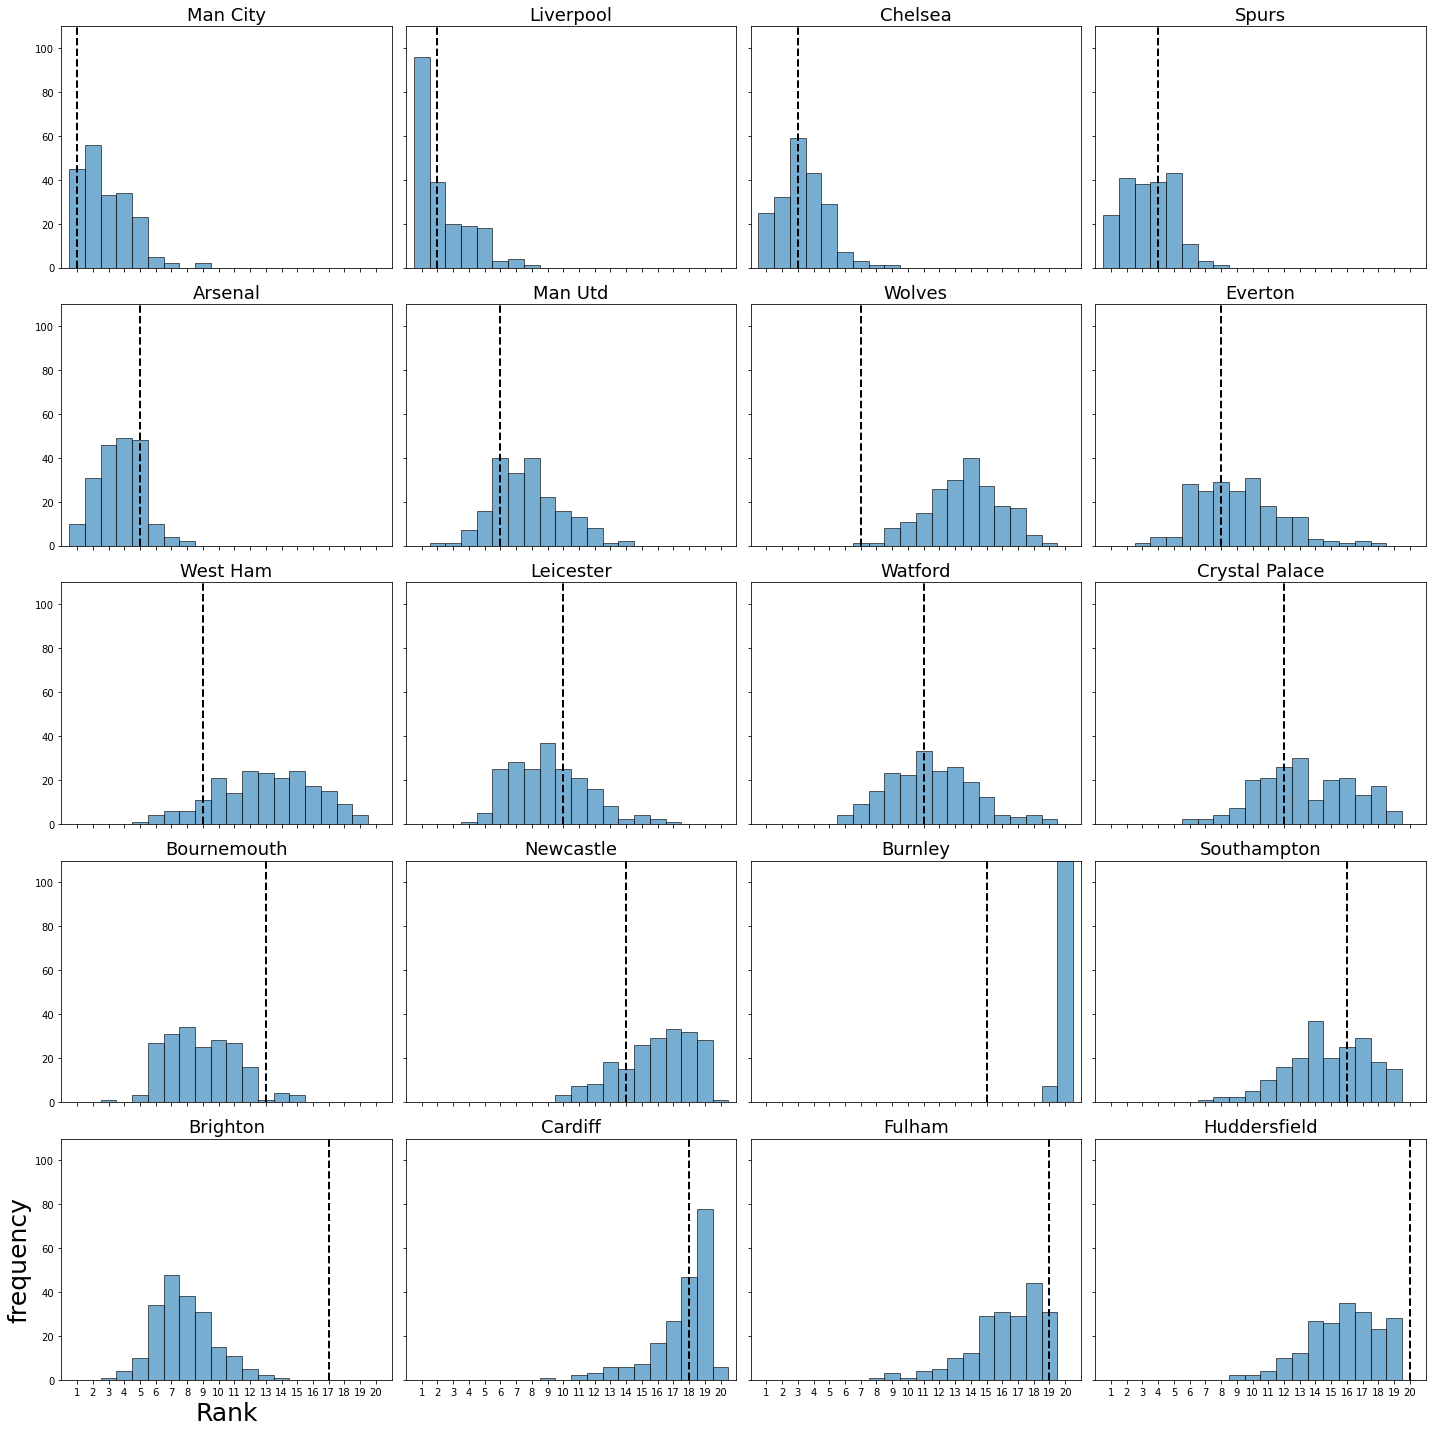

In [162]:
plot_simu_dict(sample_simu_dict)

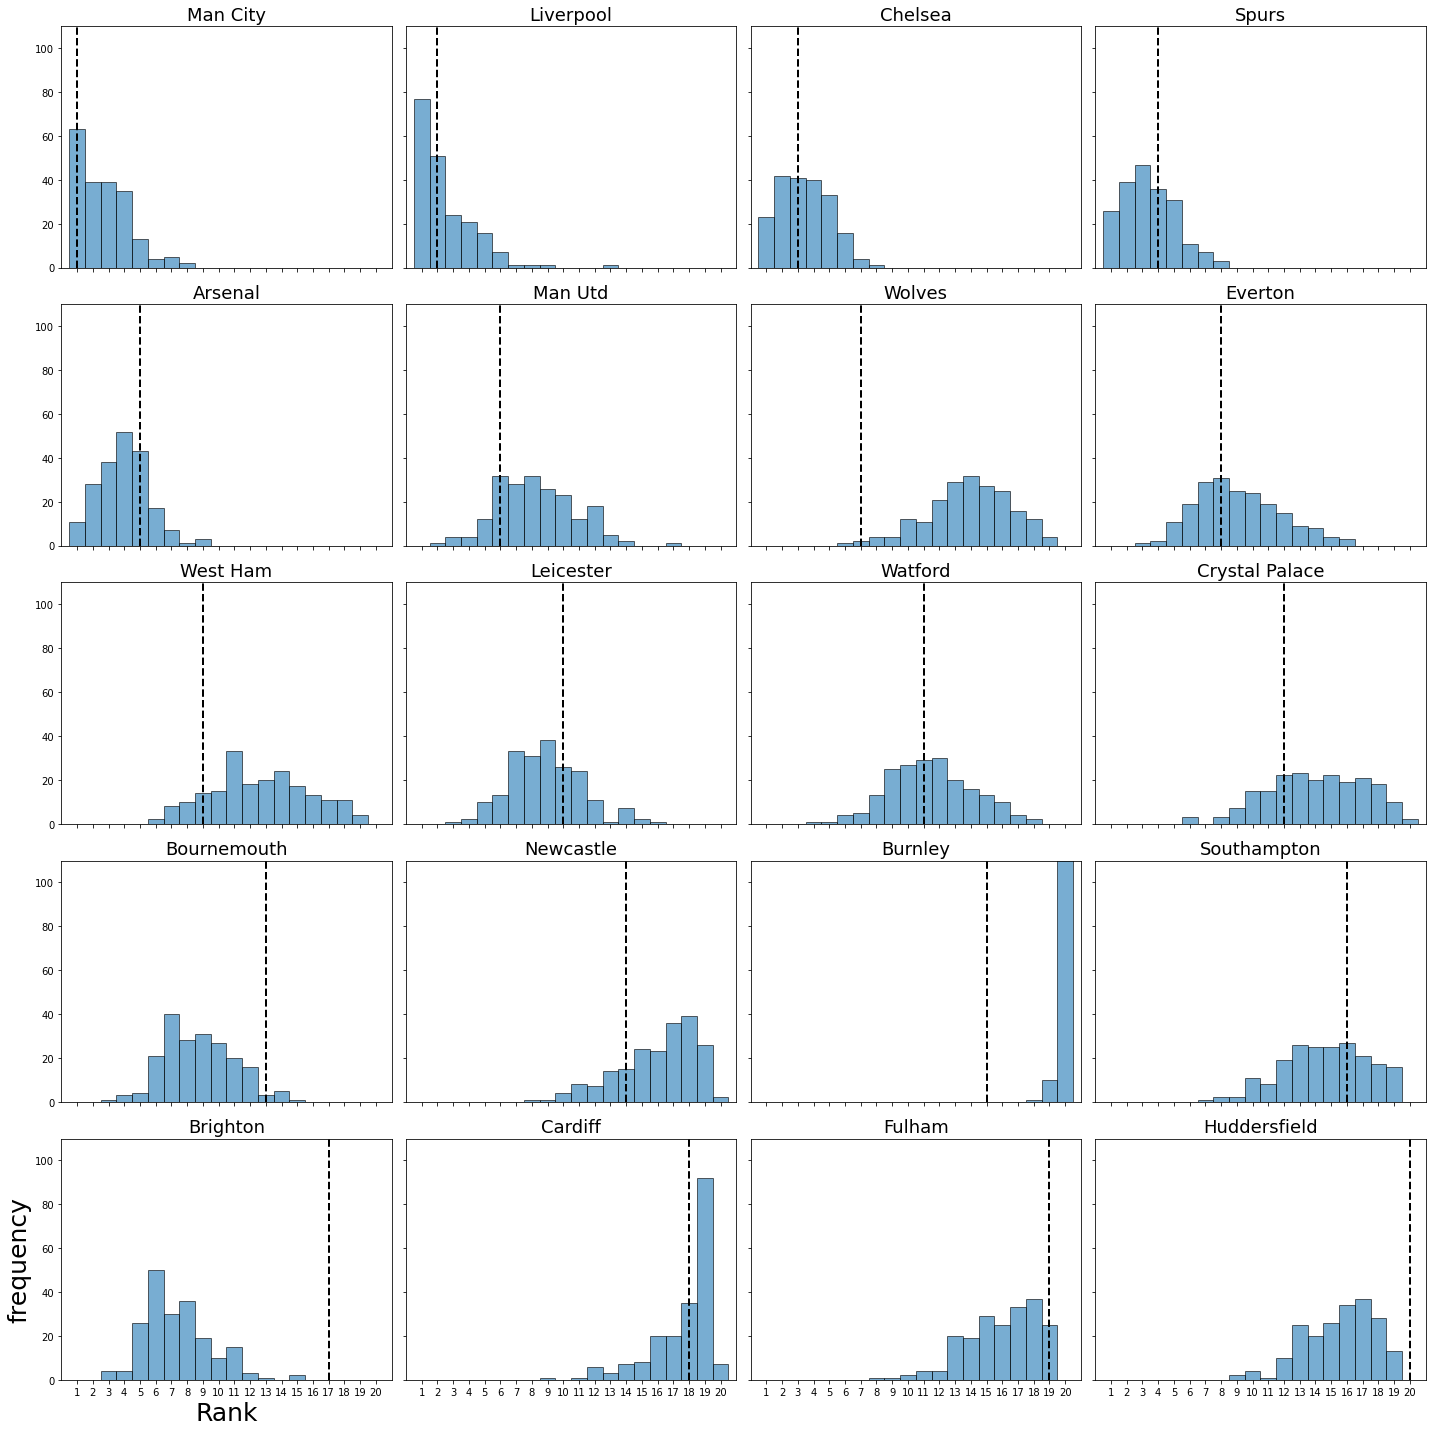

In [163]:
plot_simu_dict(resample_simu_dict)